In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import re
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Activation, Flatten
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import gensim
import gensim.downloader
from nltk.corpus import brown
import string

In [ ]:
import nltk
nltk.download('brown')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sents = brown.sents()
cleaned_sents = []
for i in sents:
    sentence = []
    for j in i :
        if j not in string.punctuation :
            sentence.append(j.lower())
    cleaned_sents.append(sentence)



In [ ]:
model = gensim.models.Word2Vec(cleaned_sents,size=50,window=7,min_count=1)

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")  

In [ ]:
train['reviews']

0        This book was very informative, covering all a...
1        I am already a baseball fan and knew a bit abo...
2        I didn't like this product it smudged all unde...
3        I simply love the product. I appreciate print ...
4        It goes on very easily and makes my eyes look ...
                               ...                        
49995                         it does not work((((((((((((
49996    Really worthless, loud motor with absolutely n...
49997    Don't waste your money on this. It does nothin...
49998    Product does not remove ear wax. No suction, j...
49999    If you wear hearing aids these are great for r...
Name: reviews, Length: 50000, dtype: object

In [ ]:
def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    lower_text = text.copy()
    for i in range(len(text)):
        lower_text[i] = text[i].lower()
    return lower_text

In [ ]:
def remove_punctuation(text):
    #stop_words = set(stopwords.words('english'))
    cleanedText = []
    for test_str in text:
        res = re.sub(r'[^\w\s]', '', test_str) 
        cleanedText.append(res)
    return cleanedText

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    without_stopwords_text  = text.copy()
    for i in range(len(text)):
        without_stopwords_text[i] = [w for w in text[i] if w not in stop_words]
    return without_stopwords_text

In [ ]:
def perform_tokenization(text):
    t = Tokenizer()
    t.fit_on_texts(text)
    encoded = t.texts_to_sequences(text)
    return encoded

In [ ]:
def get_dicts(train):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train)
    words_to_index = tokenizer.word_index
    return words_to_index

In [ ]:
# def gloveVector():
#     wordMapping = {}
#     fileName = ''
#     with open(fileName, 'r', encoding='UTF-8') as f:
#         for line in f:
#             w_line = line.split()
#             curr_word = w_line[0]
#             wordMapping[curr_word] = np.array(w_line[1:], dtype=np.float64)
#     return (wordMapping)



In [ ]:
# word_to_index = get_dicts(train)
# wordMap = gloveVector()
# vocabSize = len(word_to_index)

In [ ]:
MAX_LENGTH = 50

In [ ]:
# def embeddingMatrix():
#     vocab_len = len(word_to_index)
#     embed_vector_len = wordMap['moon'].shape[0]
#     emb_matrix = np.zeros((vocab_len, embed_vector_len))
#     for word, index in word_to_index.items():
#     embedding_vector = wordMap.get(word)
#     if embedding_vector is not None:
#         emb_matrix[index, :] = embedding_vector
#     embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=MAX_LENGTH, weights = [emb_matrix], trainable=False)
#     return embedding_layer


In [ ]:
def tokens(text):
    a = text.copy()
    for i in range(len(text)):
        a[i] = nltk.word_tokenize(text[i])
    return a

In [ ]:
def perform_padding(data):
  z=[]
  for i in data:
    k = [r for j in i for r in j]
    result = np.zeros(MAX_LENGTH*50)
    result[:len(k)] = np.array(k)
    z.append(result)
  return (np.array(z,dtype='float64'))

In [ ]:
def preprocess_data(data):
    reviews = data["reviews"]
    reviews = convert_to_lower(reviews)
    reviews = remove_punctuation(reviews)
    reviews = tokens(reviews)
    emb = []
    for i in reviews:
      tmp=[]
      for j in i:
        try:
          tmp.append(model.wv[j])
        except KeyError:
          tmp.append(np.zeros((50)))
      emb.append(tmp)
    padded = perform_padding(emb)    
    return padded

In [ ]:
preprocessed_reviews = preprocess_data(train)

In [ ]:
preprocessed_test_reviews = preprocess_data(test)

In [ ]:
def softmax_activation(x):
    exp_x = np.exp(x)
    return exp_x/np.sum(exp_x)

In [ ]:
class NeuralNetGlove:

    def __init__(self, reviews, ratings):

        self.reviews = reviews
        self.ratings = ratings

    def build_nn(self,hiddenLayers,activationHidden):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(MAX_LENGTH*50,)))
        for i in range(hiddenLayers):
            self.model.add(Dense(64,activation=activationHidden))
        self.model.add(Dense(5,activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
        self.model.summary()
        
    def train_nn(self,batch_size,epochs):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        y_train = tf.keras.utils.to_categorical(self.ratings,num_classes=5)
        self.history = self.model.fit(self.reviews, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
        

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        y_pred = self.model.predict(reviews)
        pred1 = []
        for i in range(len(y_pred)):
            pred1.append(np.argmax(y_pred[i])+1)
        return pred1

In [ ]:
train_rating_list = train['ratings'].to_list()
Y = [str(i-1) for i in train_rating_list]

In [ ]:
###### Code to find the model with best training and test set 
def bestModelNN():
    trainAccuraciesReLU = []
    testAccuraciesReLU = []
    trainAccuraciesSigmoid = []
    testAccuraciesSigmoid = []
    
    for i in range(0,5):
        M = NeuralNetGlove(preprocessed_reviews,Y)
        M.build_nn(hiddenLayers=i,activationHidden='sigmoid')
        M.train_nn(64,15)
        y_pred = M.predict(preprocessed_test_reviews)
        accuracyTest = accuracy_score(test['ratings'],y_pred)
        accuracyTrain = M.history.history['accuracy'][-1]
        trainAccuraciesSigmoid.append(accuracyTrain)
        testAccuraciesSigmoid.append(accuracyTest)
        del M
        
    for i in range(0,5):
        M = NeuralNetGlove(preprocessed_reviews,Y)
        M.build_nn(hiddenLayers=i,activationHidden='relu')
        M.train_nn(64,15)
        y_pred = M.predict(preprocessed_test_reviews)
        accuracyTest = accuracy_score(test['ratings'],y_pred)
        accuracyTrain = M.history.history['accuracy'][-1]
        trainAccuraciesReLU.append(accuracyTrain)
        testAccuraciesReLU.append(accuracyTest)
        del M 
        
    print(trainAccuraciesReLU)
    print(testAccuraciesReLU)
    print(trainAccuraciesSigmoid)
    print(testAccuraciesSigmoid)
    return trainAccuraciesReLU, testAccuraciesReLU, trainAccuraciesSigmoid, testAccuraciesSigmoid



In [ ]:
##### Develop Report for the best model and prediction for some examples
def report(y_pred,test,Model):
    Classification_report = classification_report(test['ratings'],y_pred,target_names=['1','2','3','4','5'])
    cm  = confusion_matrix(test['ratings'],y_pred)
    print("Classification Report : \n",Classification_report)
    print("Heat Map :\n")
    sns.heatmap(cm,cmap="Blues",annot=True,fmt='.4g',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5'])
    #tried_examples = [['I like it but dont think I would buy again.'], ['Nice looking cleaner but way smaller than 2 liters. Not as advertised.'],['Total waste of money, I used all 10 of these and got 0 results from it.']] 
    # Create the pandas DataFrame 
    #df = pd.DataFrame(tried_examples, columns = ['reviews']) 
    #pre_tried_examples = preprocess_data(df,word_to_index)
    #z = Model.predict(pre_tried_examples)
    #print("Examples :\n",df)
    #print("Predicted Values: \n",z)

In [ ]:
trainAccuraciesReLU, testAccuraciesReLU, trainAccuraciesSigmoid, testAccuraciesSigmoid = bestModelNN()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 12505     
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.2398 - accuracy: 0.6043 - val_loss: 1.3286 - val_accuracy: 0.5731
Epoch 2/15
625/625 [==============================] - 1s 2ms/step - loss: 1.0344 - accuracy: 0.6816 - val_loss: 1.2574 - val_accuracy: 0.5727
Epoch 3/15
625/625 [==============================] - 1s 2ms/step - loss: 0.9877 - accuracy: 0.6849 - val_loss: 1.2162 - val_accuracy: 0.5758
Epoch 4/15
625/625 [==============================] - 1s 2ms/step - loss: 0.9556 - accuracy: 0.6901 - val_loss: 1.2080 - val_accuracy: 0.5789
Epoch 5/15
625/625 [==============================] - 1s 2ms/step - loss: 0.94

### Accuracies Plots

In [ ]:
all_accuracy = pd.DataFrame(columns=['layers','train_accuracy_sigmoid','test_accuracy_sigmoid','train_accuracy_relu','test_accuracy_relu'],index=np.arange(5))

In [ ]:
all_accuracy['layers'] = np.arange(5)
all_accuracy['train_accuracy_sigmoid']= trainAccuraciesSigmoid
all_accuracy['test_accuracy_sigmoid'] = testAccuraciesSigmoid
all_accuracy['train_accuracy_relu'] = trainAccuraciesReLU
all_accuracy['test_accuracy_relu'] = testAccuraciesReLU
all_accuracy

,layers,train_accuracy_sigmoid,test_accuracy_sigmoid,train_accuracy_relu,test_accuracy_relu
0,0,0.697050,0.5905,0.697350,0.5932
1,1,0.704375,0.5927,0.771750,0.5928
2,2,0.701900,0.5979,0.781825,0.5803
3,3,0.699150,0.5991,0.797275,0.5765
4,4,0.696500,0.5987,0.801675,0.5650


In [ ]:
import matplotlib.pyplot as plt

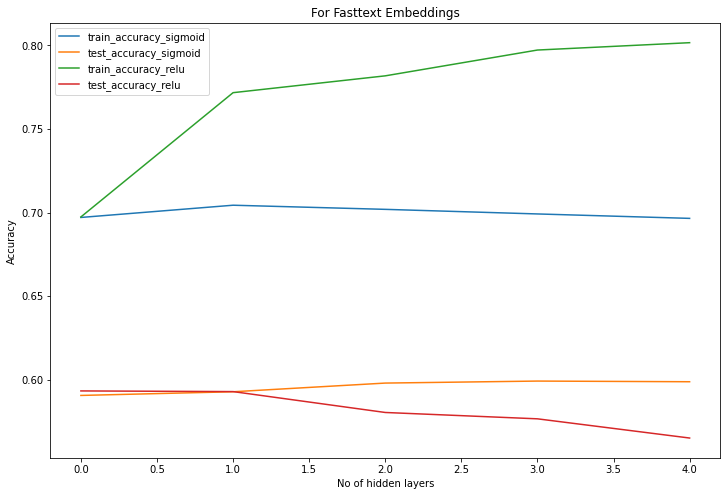

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy['layers'],all_accuracy['train_accuracy_sigmoid'],label='train_accuracy_sigmoid')
plt.plot(all_accuracy['layers'],all_accuracy['test_accuracy_sigmoid'],label='test_accuracy_sigmoid')
plt.plot(all_accuracy['layers'],all_accuracy['train_accuracy_relu'],label='train_accuracy_relu')
plt.plot(all_accuracy['layers'],all_accuracy['test_accuracy_relu'],label='test_accuracy_relu')
plt.title('For Fasttext Embeddings')
plt.xlabel("No of hidden layers")
plt.ylabel("Accuracy")
plt.legend()


### Best Model:
1. Hidden Layers:
2. Activation

In [ ]:
Best_model = NeuralNetGlove(preprocessed_reviews,Y)
Best_model.build_nn(hiddenLayers=1,activationHidden='relu')
Best_model.train_nn(64,15)
y_pred = Best_model.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = Best_model.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                160064    
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 325       
Total params: 160,389
Trainable params: 160,389
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 3s 4ms/step - loss: 1.0942 - accuracy: 0.6744 - val_loss: 1.2291 - val_accuracy: 0.5760
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9594 - accuracy: 0.6862 - val_loss: 1.1888 - val_accuracy: 0.5828
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9071 - accuracy: 0.6945 - val_loss: 1.1739 - val_accuracy: 0.5882
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.8665 - 

##### Report for Best Model

Classification Report : 
               precision    recall  f1-score   support

           1       0.45      0.17      0.25      1271
           2       0.16      0.04      0.07       630
           3       0.25      0.11      0.15       911
           4       0.24      0.08      0.12      1404
           5       0.64      0.94      0.76      5784

    accuracy                           0.59     10000
   macro avg       0.35      0.27      0.27     10000
weighted avg       0.49      0.59      0.51     10000

Heat Map :



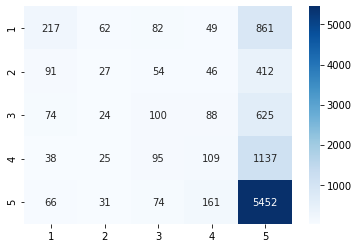

In [ ]:
report(y_pred,test,Model=Best_model)


## Predction GUI

In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
def preprocess_test(input):
  input = input.split()
  
  input = convert_to_lower(input)
  input = tokens(input)
  emb=[]
  for i in input:
    try:
      emb.append(model.wv[i])
    except KeyError:
      emb.append(np.zeros((50)))
  padded = perform_padding(emb)    
  return padded


In [ ]:
k = widgets.Textarea(
    value="",
    placeholder='Type something',
    description='String:',
    disabled=False)
button = widgets.Button(description="Predict!")
output = widgets.Output()
display(k,button, output)
def on_button_clicked(b):
    output.clear_output()
    if k.value == "":
      output.clear_output()
    else :
        with output:
        text = preprocess_test(k.value)
        tmp=[]
        for i in text:
          for j in i:
            tmp.append(j)
        text_ = np.zeros(2500)
        text_[:len(tmp)]=tmp

        prediction = Best_model.predict(np.array([text_]))
        print("Predicted Sentiment:",prediction[0])
    
button.on_click(on_button_clicked)

Textarea(value='', description='String:', placeholder='Type something')

Button(description='Predict!', style=ButtonStyle())

Output()

### Different Models

##### Hidden Layers:0, Activation:Sigmoid

In [ ]:
Sigmoid0 = NeuralNetGlove(preprocessed_reviews,Y)
Sigmoid0.build_nn(hiddenLayers=0,activationHidden='sigmoid')
Sigmoid0.train_nn(64,15)
y_pred = Sigmoid0.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = Sigmoid0.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 5)                 12505     
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.2249 - accuracy: 0.6104 - val_loss: 1.3405 - val_accuracy: 0.5721
Epoch 2/15
625/625 [==============================] - 1s 2ms/step - loss: 1.0387 - accuracy: 0.6788 - val_loss: 1.2842 - val_accuracy: 0.5739
Epoch 3/15
625/625 [==============================] - 1s 2ms/step - loss: 0.9971 - accuracy: 0.6817 - val_loss: 1.2340 - val_accuracy: 0.5759
Epoch 4/15
625/625 [==============================] - 1s 2ms/step - loss: 0.9532 - accuracy: 0.6918 - val_loss: 1.1996 - val_accuracy: 0.5776
Epoch 5/15
625/625 [==============================] - 1s 2ms/step - loss: 0

Classification Report : 
               precision    recall  f1-score   support

           1       0.45      0.13      0.21      1271
           2       0.16      0.01      0.02       630
           3       0.28      0.08      0.12       911
           4       0.26      0.04      0.06      1404
           5       0.62      0.97      0.76      5784

    accuracy                           0.59     10000
   macro avg       0.35      0.25      0.23     10000
weighted avg       0.49      0.59      0.48     10000

Heat Map :



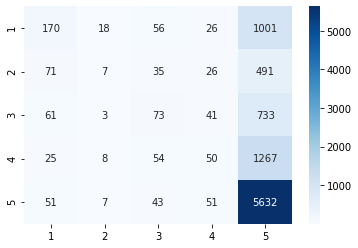

In [ ]:
report(y_pred,test,Model=Sigmoid0)

##### Hidden Layers:1, Activation: Sigmoid

In [ ]:
Sigmoid1 = NeuralNetGlove(preprocessed_reviews,Y)
Sigmoid1.build_nn(hiddenLayers=1,activationHidden='sigmoid')
Sigmoid1.train_nn(64,15)
y_pred = Sigmoid1.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = Sigmoid1.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                160064    
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 325       
Total params: 160,389
Trainable params: 160,389
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.1288 - accuracy: 0.6312 - val_loss: 1.2560 - val_accuracy: 0.5741
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9841 - accuracy: 0.6884 - val_loss: 1.2050 - val_accuracy: 0.5741
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9609 - accuracy: 0.6831 - val_loss: 1.1801 - val_accuracy: 0.5773
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9233 - 

Classification Report : 
               precision    recall  f1-score   support

           1       0.46      0.15      0.23      1271
           2       0.12      0.02      0.03       630
           3       0.28      0.08      0.12       911
           4       0.25      0.01      0.02      1404
           5       0.62      0.98      0.76      5784

    accuracy                           0.60     10000
   macro avg       0.35      0.25      0.23     10000
weighted avg       0.48      0.60      0.48     10000

Heat Map :



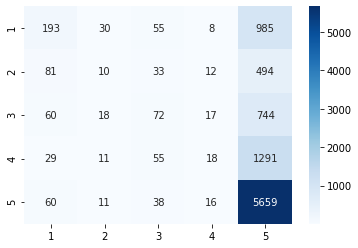

In [ ]:
report(y_pred,test,Model=Sigmoid1)

##### Hidden layers:0, Activation: ReLU

In [ ]:
ReLU0 = NeuralNetGlove(preprocessed_reviews,Y)
ReLU0.build_nn(hiddenLayers=0,activationHidden='relu')
ReLU0.train_nn(64,15)
y_pred = ReLU0.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = ReLU0.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 5)                 12505     
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.2316 - accuracy: 0.6098 - val_loss: 1.3089 - val_accuracy: 0.5720
Epoch 2/15
625/625 [==============================] - 1s 2ms/step - loss: 1.0329 - accuracy: 0.6821 - val_loss: 1.2425 - val_accuracy: 0.5753
Epoch 3/15
625/625 [==============================] - 1s 2ms/step - loss: 0.9813 - accuracy: 0.6899 - val_loss: 1.2179 - val_accuracy: 0.5772
Epoch 4/15
625/625 [==============================] - 1s 2ms/step - loss: 0.9640 - accuracy: 0.6857 - val_loss: 1.1951 - val_accuracy: 0.5799
Epoch 5/15
625/625 [==============================] - 1s 2ms/step - loss: 0

Classification Report : 
               precision    recall  f1-score   support

           1       0.49      0.10      0.17      1271
           2       0.14      0.01      0.02       630
           3       0.28      0.06      0.10       911
           4       0.28      0.04      0.06      1404
           5       0.61      0.98      0.75      5784

    accuracy                           0.59     10000
   macro avg       0.36      0.24      0.22     10000
weighted avg       0.49      0.59      0.48     10000

Heat Map :



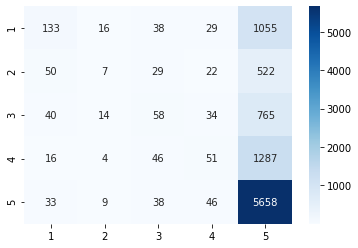

In [ ]:
report(y_pred,test,Model=ReLU0)

##### Hidden layers:1, Activation:ReLU

In [ ]:
ReLU1 = NeuralNetGlove(preprocessed_reviews,Y)
ReLU1.build_nn(hiddenLayers=1,activationHidden='relu')
ReLU1.train_nn(64,15)
y_pred = ReLU1.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = ReLU1.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                160064    
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 325       
Total params: 160,389
Trainable params: 160,389
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 3s 4ms/step - loss: 1.1022 - accuracy: 0.6682 - val_loss: 1.2359 - val_accuracy: 0.5763
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9511 - accuracy: 0.6893 - val_loss: 1.2008 - val_accuracy: 0.5807
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9098 - accuracy: 0.6923 - val_loss: 1.1724 - val_accuracy: 0.5862
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.8701 - 

Classification Report : 
               precision    recall  f1-score   support

           1       0.44      0.18      0.26      1271
           2       0.14      0.03      0.04       630
           3       0.24      0.10      0.14       911
           4       0.27      0.07      0.11      1404
           5       0.63      0.95      0.76      5784

    accuracy                           0.59     10000
   macro avg       0.35      0.26      0.26     10000
weighted avg       0.49      0.59      0.50     10000

Heat Map :



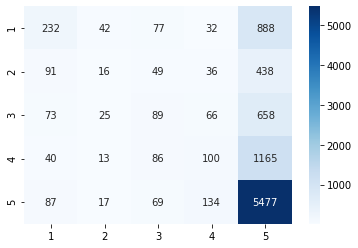

In [ ]:
report(y_pred,test,Model=ReLU1)